In [37]:
# libraries needed to start spark session
import pyspark
from pyspark.sql import SparkSession

# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

# for everything else
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
from progressbar import ProgressBar
import pickle

In [1]:
# start new spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("drones") \
    .getOrCreate()

# to view events/jobs in current spark session:
spark

#spark.stop()

In [39]:
# read in as binary
df1 = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.png") \
    .option("recursiveFileLookup", "true") \
    .load("D:\Drone_project\training\00001.png")
df1.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [40]:
df1.show(2)

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/Users/Simbo...|2022-03-10 15:16:...|2175304|[89 50 4E 47 0D 0...|
|file:/Users/Simbo...|2022-03-10 15:16:...|2174852|[89 50 4E 47 0D 0...|
+--------------------+--------------------+-------+--------------------+
only showing top 2 rows



In [41]:
df2 = df1.rdd.map(lambda x: x["content"])

In [42]:
n_images = df2.count()
n_images

36

In [43]:
content = df2.take(n_images)

In [44]:
# Using the VGG16 model from keras
# https://keras.io/api/applications/vgg/#vgg16-function
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [49]:
# https://github.com/keras-team/keras/issues/11684
from PIL import Image
import io

data = {}

for i in range(n_images):
    try:
        img = Image.open(io.BytesIO(content[i]))
        img1 = img.convert('RGB')
        img1 = img1.resize((224,224))
    
        img2 = np.array(img1)
        reshaped_img = img2.reshape(1,224,224,3)
        imgx = preprocess_input(reshaped_img)
        features = model.predict(imgx, use_multiprocessing=True)
        data[i] = features
    
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open("/Users/Simbo/Desktop/Spring 2022/SE413/airborne-detection-starter-kit/data/test.pkl",'wb') as file:
            pickle.dump(data,file)
            
with open('data.pickle','wb') as file:
    pickle.dump(data,file)

In [47]:
with open('data.pickle','rb') as file:
    data = pickle.load(file)

In [50]:
data

{0: array([[0.42480665, 0.36689585, 2.7618694 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 1: array([[0.51456   , 0.92237103, 2.6840706 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 2: array([[0.5638341 , 0.43064106, 2.708096  , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 3: array([[0.42203388, 0.7266675 , 2.7904391 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 4: array([[0.09426183, 0.12920922, 2.623754  , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 5: array([[0.24795407, 0.08083811, 2.9164834 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 6: array([[0.3037884 , 0.5939039 , 2.876521  , ..., 0.        , 0.        ,
         0.04715949]], dtype=float32),
 7: array([[0.00524414, 0.0911229 , 2.5493188 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 8: array([[0.3168396 , 1.7976341 , 3.1377063 , ..., 0.67525864, 0.     

In [61]:
feat = np.array(list(data.values())).reshape(-1,4096)
pca = PCA(n_components = 36, random_state = 22)
pca.fit(feat)
x = pca.transform(feat)

In [62]:
print("Components before PCA:", feat.shape[1])
print("Components after PCA:", pca.n_components)

Components before PCA: 4096
Components after PCA: 36


In [63]:
kmeans = KMeans(n_clusters=4, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=4, random_state=22)

In [64]:
kmeans.labels_

array([0, 0, 0, 3, 0, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [66]:
# holds the cluster id and the images { id: [images] }

groups = {}
for file, cluster in zip(data.keys(),kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
groups[1]

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [ ]:
# Create folders for each cluster in host
for i in range(len(unique_labels)):
    # makeadir() evaluates your condition
    out_path = 'D:\Clusters\{}'.format(i)
    if not os.path.exists(out_path):
        os.mkdir(out_path)

In [ ]:
pbar = ProgressBar()

In [ ]:
# Put all images of each cluster into thier respective folders on host for examination
source_path = r"D:\training"
# Create array from images in source path
source_list = []
for images in os.scandir(source_path):
        source_list.append(images)
# For loor copies images over into the clustered folders
for i in pbar2(range(len(kmeans.labels_))):
    folder = kmeans.labels_[i]
    out_path = r'D:\Clusters\{}'.format(folder)
    image_select = source_list[i]
    shutil.copy(image_select, out_path)

In [67]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(2, 12))

In [68]:
for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

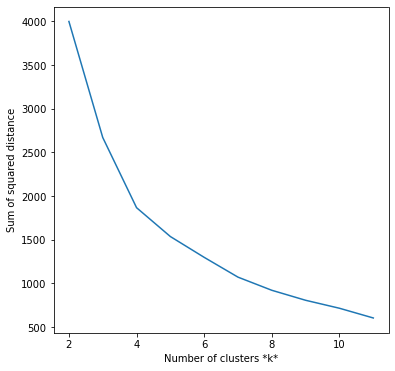

In [69]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [9]:
from keras.applications.vgg16 import preprocess_input
import numpy as np

img2 = np.array(img1)
reshaped_img = img2.reshape(1,224,224,3)
imgx = preprocess_input(reshaped_img)

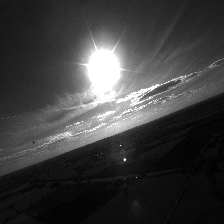

In [12]:
from keras.preprocessing.image import load_img 
img1 = load_img("/Users/Simbo/Desktop/Spring 2022/SE413/airborne-detection-starter-kit/data/part1/Images/part1570826a12876427ca77c045424de1f51/1538148607237886629570826a12876427ca77c045424de1f51.png", target_size=(224,224))
img2 = np.array(img1)
reshaped_img = img2.reshape(1,224,224,3)
imgx = preprocess_input(reshaped_img)
img1

In [ ]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
# lop through each image in the dataset
data = {}
p = r"D:\features.pkl"
pbar = ProgressBar()
for drone_image in pbar(drone_images):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(drone_image,model)
        data[drone_image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

In [ ]:
with open('data.pickle','wb') as file:
            pickle.dump(data,file)

In [ ]:
with open('data.pickle','rb') as file:
    data = pickle.load(file)

In [ ]:
# https://docs.delta.io/latest/quick-start.html
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("drones") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [ ]:
# https://stackoverflow.com/questions/67705881/unable-to-read-images-simultaneously-in-parallels-using-pyspark
from pyspark.ml.image import ImageSchema
import numpy as np

# Pre-caching the required schema. If you remove this line an error will be raised.
ImageSchema.imageFields

# Transforming images to np.array
arrays = df1.rdd.map(ImageSchema.toNDArray).collect()

img = np.array(arrays)
print(img.shape)

In [ ]:
import sparkdl
df = sparkdl.readImages("/Users/Simbo/Desktop/Spring 2022/SE413/airborne-detection-starter-kit/data/part1/Images/part1570826a12876427ca77c045424de1f51")